In [40]:
import os
import random

import cv2
import albumentations as A
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from albumentations.pytorch import ToTensorV2
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import multilabel_confusion_matrix
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm, trange

from sklearn.metrics import f1_score



In [41]:
# randomness 제어를 위한 시드 고정 (학습 결과 재현을 위해 고정)
def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.cuda.empty_cache()


# 시드 값 선택
SEED = 42
set_seed(SEED)

# 학습 장치 결정
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [43]:
##### tqdm 사용법 #####
import time

# trange
for i in trange(100):
    time.sleep(0.01)

# tqdm
for _ in tqdm(list(range(100))):
    time.sleep(0.01)

# iterable 객체는 모두 사용 가능, zip()이나 enumerate()와 같이 __len__()이 없는 경우 total=len(a)와 같이 명시
for _ in tqdm(zip(list(range(100)), list(range(100))), total=len(range(100))):
    time.sleep(0.01)

# 이중 반복문에서 사용
for _ in tqdm(list(range(5))):
    for _ in tqdm(list(range(100))):
        time.sleep(0.01)

100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


## Data Preprocessing

In [44]:
# 경로 설정 (로컬 환경인 경우 자신의 경로로 설정)
root_dir = './2024-dl-final/'

train_dir = root_dir + 'train/'
train_w2v_dir = root_dir + 'train_w2v/'
test_dir = root_dir + 'test/'
test_w2v_dir = root_dir + 'test_w2v/'

In [45]:
train_df = pd.read_csv(root_dir + 'train.csv')
test_df = pd.read_csv(root_dir + 'test.csv')

In [46]:
train_df.head(5)

,id,path,w2v_path,title,year,genres
0,13,/kaggle/input/2024-dl-final/train/13.jpg,/kaggle/input/2024-dl-final/train_w2v/13.npy,Forrest Gump,1994,"['Comedy', 'Drama', 'Romance']"
1,55,/kaggle/input/2024-dl-final/train/55.jpg,/kaggle/input/2024-dl-final/train_w2v/55.npy,Amores Perros,2000,"['Drama', 'Thriller']"
2,64,/kaggle/input/2024-dl-final/train/64.jpg,/kaggle/input/2024-dl-final/train_w2v/64.npy,Talk to Her,2002,"['Drama', 'Romance']"
3,80,/kaggle/input/2024-dl-final/train/80.jpg,/kaggle/input/2024-dl-final/train_w2v/80.npy,Before Sunset,2004,"['Drama', 'Romance']"
4,86,/kaggle/input/2024-dl-final/train/86.jpg,/kaggle/input/2024-dl-final/train_w2v/86.npy,The Elementary Particles,2006,"['Drama', 'Romance']"


In [47]:
test_df.head(5)

,id,path,w2v_path,title,year
0,32,/kaggle/input/2024-dl-final/test/32.jpg,/kaggle/input/2024-dl-final/test_w2v/32.npy,Cannon Fodder,1995
1,91,/kaggle/input/2024-dl-final/test/91.jpg,/kaggle/input/2024-dl-final/test_w2v/91.npy,Land Without Bread,1933
2,114,/kaggle/input/2024-dl-final/test/114.jpg,/kaggle/input/2024-dl-final/test_w2v/114.npy,Pretty Woman,1990
3,142,/kaggle/input/2024-dl-final/test/142.jpg,/kaggle/input/2024-dl-final/test_w2v/142.npy,Brokeback Mountain,2005
4,156,/kaggle/input/2024-dl-final/test/156.jpg,/kaggle/input/2024-dl-final/test_w2v/156.npy,Wilbur Wants to Kill Himself,2002


In [48]:
# str -> list 변환 ("['Romance', 'Action', ...]" -> ['Romance', 'Action', ...])
train_df['genres'] = train_df['genres'].apply(lambda x: eval(x))
# train_df['genres']의 행 : ['Romance', 'Action', ...] 형태
# multi label encoding
mlb = MultiLabelBinarizer() # 다중 레이블 분류 문제에서, 레이블 리스트 열을 넣어주면 자동으로 레이블 종류(개수)를 인식하고 레이블 인코딩 수행 
train_label = mlb.fit_transform(train_df['genres'])

# column 순서 확인
mlb.classes_ 

array(['Action', 'Animation', 'Comedy', 'Documentary', 'Drama', 'Horror',
       'Romance', 'Thriller'], dtype=object)

In [49]:
train_label # ex) 장르가 Action인 영화는 [1,0,0,0,0,0,0,0]로 표현됨

array([[0, 0, 1, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [50]:
mlb_train = pd.DataFrame(train_label, columns=mlb.classes_) # train_label을 각 열로 분할 (열 이름 : 레이블 명)

train_df = pd.concat([train_df, mlb_train], axis=1) # 기존 데이터와 결합

train_df.head()

,id,path,w2v_path,title,year,genres,Action,Animation,Comedy,Documentary,Drama,Horror,Romance,Thriller
0,13,/kaggle/input/2024-dl-final/train/13.jpg,/kaggle/input/2024-dl-final/train_w2v/13.npy,Forrest Gump,1994,"[Comedy, Drama, Romance]",0,0,1,0,1,0,1,0
1,55,/kaggle/input/2024-dl-final/train/55.jpg,/kaggle/input/2024-dl-final/train_w2v/55.npy,Amores Perros,2000,"[Drama, Thriller]",0,0,0,0,1,0,0,1
2,64,/kaggle/input/2024-dl-final/train/64.jpg,/kaggle/input/2024-dl-final/train_w2v/64.npy,Talk to Her,2002,"[Drama, Romance]",0,0,0,0,1,0,1,0
3,80,/kaggle/input/2024-dl-final/train/80.jpg,/kaggle/input/2024-dl-final/train_w2v/80.npy,Before Sunset,2004,"[Drama, Romance]",0,0,0,0,1,0,1,0
4,86,/kaggle/input/2024-dl-final/train/86.jpg,/kaggle/input/2024-dl-final/train_w2v/86.npy,The Elementary Particles,2006,"[Drama, Romance]",0,0,0,0,1,0,1,0


In [51]:
# 로컬 환경에서 학습하는 경우 - csv 파일의 경로를 로컬 환경에 맞게 수정
train_df['path'] = train_df['path'].apply(lambda x: train_dir + x.split('/')[-1])
test_df['path'] = test_df['path'].apply(lambda x: test_dir + x.split('/')[-1])
train_df['w2v_path'] = train_df['w2v_path'].apply(lambda x: train_w2v_dir + x.split('/')[-1])
test_df['w2v_path'] = test_df['w2v_path'].apply(lambda x: test_w2v_dir + x.split('/')[-1])

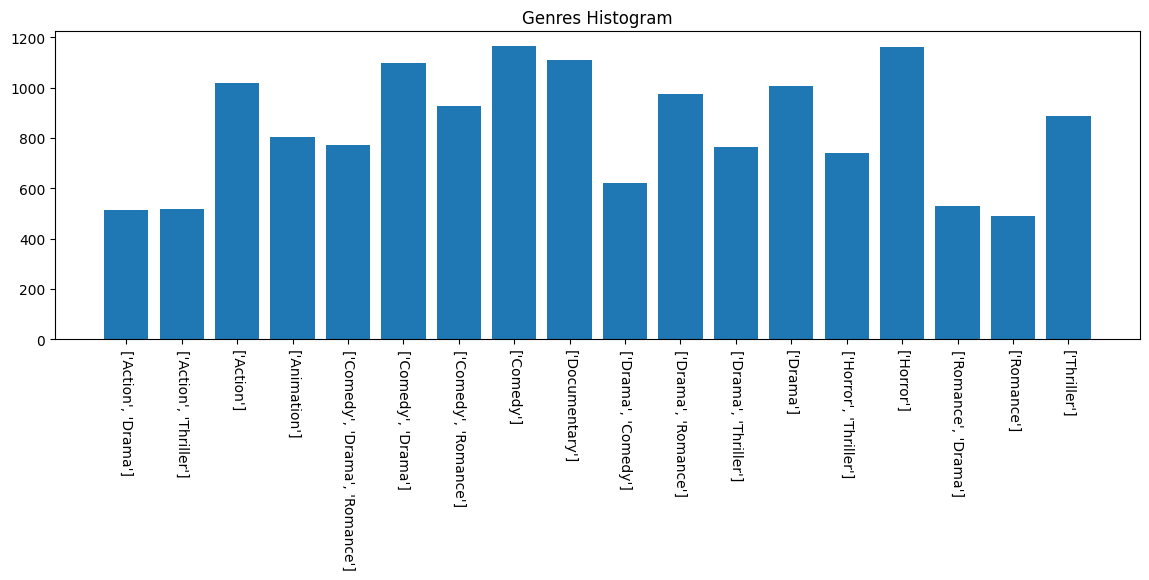

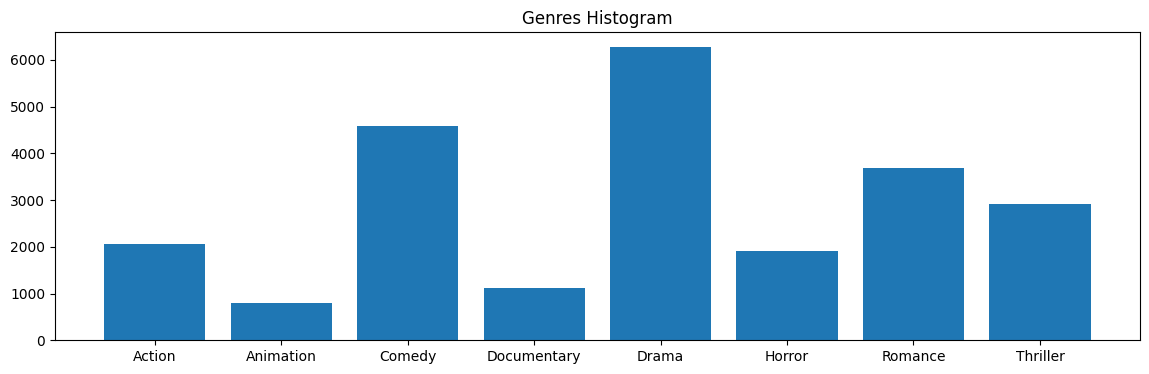

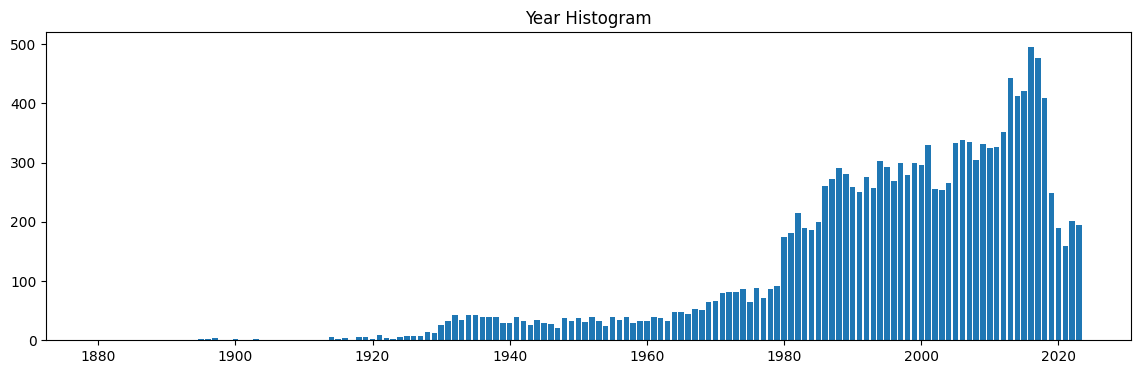

In [52]:
# multi-label을 하나의 class로 보는 경우의 히스토그램
tr_hist = train_df['genres'].apply(lambda x: str(x)).sort_values() #train_df['genres']의 각 요소를 str로 변환 ([Drama, Thriller]->"[Drama, Thriller]") -> 문자열 정렬
plt.figure(figsize=(14, 4))
plt.bar(tr_hist.unique(), tr_hist.value_counts().sort_index())
plt.xticks(rotation=-90)
plt.title('Genres Histogram')
plt.show()

# single-label을 하나의 class로 보는 경우의 히스토그램
mlb_hist = mlb_train.sum(axis=0)
plt.figure(figsize=(14, 4))
plt.bar(mlb.classes_, mlb_hist)
plt.title('Genres Histogram')
plt.show()


# 연도별 영화 히스토그램
plt.figure(figsize=(14, 4))
plt.bar(train_df['year'].sort_values().unique(), train_df['year'].value_counts().sort_index())
plt.title('Year Histogram')
plt.show()

## Dataset & Dataloader

In [53]:
class MovieDataset(Dataset): # Dataset : PyTorch의 데이터셋을 생성하기 위해 상속하는 기본 클래스
    def __init__(self, df, transform=None, mode='train'):
        # 인자로 입력받은 데이터들을 변수에 저장 
        self.df = df # 데이터 
        self.transform = transform # 이미지에 적용할 증강 정의
        self.mode = mode # train / test 모드 지정

    def __len__(self):
        return len(self.df) # 데이터셋의 길이 반화 (= 행 수 = 샘플 수)

    def __getitem__(self, idx):
        # 이미지 로드 및 변환
        image = cv2.cvtColor(cv2.imread(self.df.iloc[idx, 1]), cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        # Word2Vec 벡터 로드
        w2v = torch.tensor(np.load(self.df.iloc[idx, 2]), dtype=torch.float32)  # [15, 300]
        w2v = torch.mean(w2v, dim=0)  # 평균 계산하여 [300]으로 변환

        # 레이블 로드
        label = torch.tensor(self.df.iloc[idx, 6:].to_numpy(dtype=np.float32))
        
        return image, w2v, label


In [54]:
# 학습 데이터에 적용할 transform
train_transform = A.Compose([
    A.RandomResizedCrop(height=224, width=224, scale=(0.8, 1.0)),  # 랜덤 크롭 후 리사이즈
    A.HorizontalFlip(p=0.5),  # 좌우 뒤집기
    A.RandomBrightnessContrast(p=0.2),  # 밝기와 대비 변경
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.5),  # 이동, 확대/축소, 회전
    A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    A.GaussianBlur(blur_limit=(3, 7), p=0.5),

    A.Normalize(),  # 정규화
    ToTensorV2(),  # 텐서 변환
])

# 테스트 데이터에 적용할 transform
test_transform = A.Compose([
    A.Resize(height=224, width=224),  # 크기 변경

    A.Normalize(),  # 정규화
    ToTensorV2(),  # 텐서 변환
])


In [ ]:
batch_size = 64 # 한 배치 당 사용할 데이터 개수 
num_workers = 10  # 데이터 불러올 때 사용할 스레드(worker, 병렬 프로세스) 수 (num_workers=0 : 데이터를 메인 프로세스에서 불러오도록 설정한 것)
# num_workers를 cpu의 코어 수에 따라 조정하면 데이터 로딩 속도 향상 가능 

# data split 
# train/validation 분리
train_df, val_df = train_test_split(train_df, test_size=0.2, shuffle=True, random_state=SEED,
                                    stratify=train_df['genres'])

# MovieDataset class의 Dataset 객체 생성 
train_dataset = MovieDataset(df=train_df, transform=train_transform)
val_dataset = MovieDataset(df=val_df, transform=test_transform) # validation도 test_transform 적용
test_dataset = MovieDataset(df=test_df, transform=test_transform, mode='test')

# data loader : 객체로부터 데이터를 배치 단위로 불러오고, 병렬 처리를 통해 데이터 로딩 속도를 높임
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)

train_dataset.__len__(), val_dataset.__len__(), test_dataset.__len__() # __len__() : MovieDataset class에서 정의한, 길이 반환하는 메서드 

(12080, 3021, 5034)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

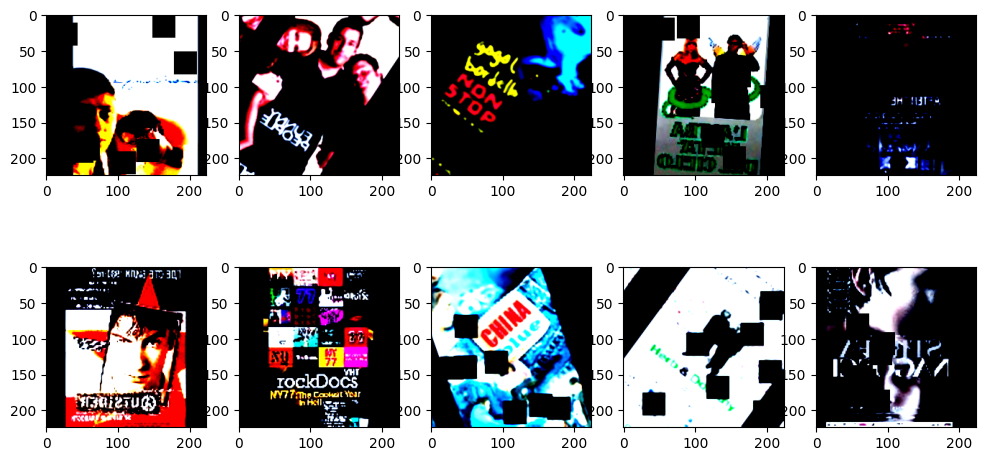

In [56]:
imgs = []
for i in range(10):
    img, _, _ = train_dataset.__getitem__(i)  # transform이 적용된 이미지 반환
    img = img.permute((1, 2, 0)).float()
    imgs.append(img.numpy())  # (3, 128, 128) 형태의 image를 (128, 128, 3) 형태로 바꿔서 저장

fig = plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(imgs[i])

plt.show()

In [57]:
for _, w2v, _ in train_loader:
    print(f"W2V shape: {w2v.shape}")  # 예상: [batch_size, 300]
    break


W2V shape: torch.Size([64, 300])


## Model

In [58]:
img.shape # [224, 224, 3]

torch.Size([224, 224, 3])

In [ ]:
class MovieClassifier(nn.Module):
    def __init__(self, num_classes, w2v_dim=300):
        super(MovieClassifier, self).__init__()
        self.num_classes = num_classes
        self.w2v_dim = w2v_dim
        # CNN 레이어 정의 (input image size : [224, 224, 3])
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # Conv1: 출력 (Channels = 32, height = 224, width = 224)
            nn.BatchNorm2d(32),  # BatchNorm 추가            
            # Conv 출력 크기 = {(input_size + 2*Padding - Kernel_size)/Stride} +1
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # Pool1: 출력 (32, 112, 112)
            # Pooling 출력 크기 = {(input_size - Kernel_size)/Stride}+1

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # Conv2: 출력 (64, 112, 112)
            nn.BatchNorm2d(64),  # BatchNorm 추가
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # Pool2: 출력 (64, 56, 56)

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),# Conv3: 출력 (128, 56, 56)
            nn.BatchNorm2d(128),  # BatchNorm 추가
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # Pool3: 출력 (128, 28, 28)

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),# Conv4: 출력 (256, 28, 28)
            nn.BatchNorm2d(256),  # BatchNorm 추가
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)                  # Pool4: 출력 (256, 14, 14)
        )
                # Word2Vec 처리 레이어 (텍스트 처리)
        self.w2v_fc = nn.Sequential(
            nn.Linear(w2v_dim, 512),  # Word2Vec 벡터를 512차원으로 변환
            nn.BatchNorm1d(512),  # BatchNorm 추가
            nn.ReLU(),
            nn.Dropout(p=0.5)
        )
                # FC 레이어 정의
        self.fc = nn.Sequential(
            nn.Linear(256 * 14 * 14 + 512, 1024),  # CNN 출력 + Word2Vec 출력 크기를 입력으로 처리
            nn.BatchNorm1d(1024),  # BatchNorm 추가
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1024, num_classes)
        )


    def forward(self, img, w2v):
        # CNN을 통해 이미지 처리
        cnn_out = self.cnn(img)
        cnn_out = cnn_out.view(cnn_out.size(0), -1)  # Flatten (2D 텐서로 변환)

        # Word2Vec 처리
        w2v_out = self.w2v_fc(w2v)

        # 두 출력 결합
        combined = torch.cat((cnn_out, w2v_out), dim=1)

        # 최종 FC 레이어 처리
        output = self.fc(combined)
        return output


In [60]:
for _, w2v, _ in train_loader:
    print(f"W2V shape: {w2v.shape}")  # 예상: [batch_size, 300]
    break

W2V shape: torch.Size([64, 300])


In [61]:
w2v_dim = 300
num_classes = mlb.classes_.shape[0]
model = MovieClassifier(num_classes,w2v_dim).to(device)

## Loss & Optimizer

In [62]:
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)


## Train & Validation

In [63]:
def train_one_epoch(model, train_loader, optimizer, criterion):
    model.train()  # 모델을 학습 모드로 설정
    running_loss = 0.0
    correct = 0
    total = 0

    for img, w2v, labels in train_loader:  # image, wav2vec, labels -> wav2vec를 사용하지 않는 경우 _로 무시
        # 데이터를 GPU로 이동
        img, w2v, labels = img.to(device), w2v.to(device), labels.to(device)
        
        # # 디바이스 확인
        # print(f"Image device: {img.device}")    # 예: cuda:0
        # print(f"W2V device: {w2v.device}")     # 예: cuda:0
        # print(f"Labels device: {labels.device}")  # 예: cuda:0
        # break
        # 옵티마이저 초기화
        optimizer.zero_grad()
        # 순전파
        outputs = model(img, w2v)
        # 손실 계산
        loss = criterion(outputs, labels)
        # 역전파
        loss.backward()
        # 파라미터 업데이트
        optimizer.step()
        # 손실 누적
        running_loss += loss.item()
        # 예측 계산 (시그모이드 + 임계값 적용)
        preds = torch.sigmoid(outputs) > 0.5
        # 정확도 계산
        correct += (preds == labels).sum().item()
        total += labels.numel()

    # 에포크당 평균 손실과 정확도 반환
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    return train_loss, train_accuracy


In [64]:
def validate_one_epoch(model, val_loader, criterion):
    model.eval()  # 모델을 평가 모드로 설정
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # 평가 시에는 그래디언트 비활성화
        for img, w2v, labels in val_loader:
            # 데이터를 GPU로 이동
            img, w2v, labels = img.to(device), w2v.to(device), labels.to(device)

            # 순전파
            outputs = model(img, w2v)

            # 손실 계산
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # 예측 계산 (시그모이드 + 임계값 적용)
            preds = torch.sigmoid(outputs) > 0.5

            # 정확도 계산
            correct += (preds == labels).sum().item()
            total += labels.numel()

    # 손실 및 정확도 계산
    val_loss = running_loss / len(val_loader)
    val_accuracy = correct / total
    return val_loss, val_accuracy


In [65]:
import matplotlib.pyplot as plt

# 학습 및 검증 손실을 저장할 리스트
train_losses = []
val_losses = []

num_epochs = 40
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # 학습 단계
    train_loss, train_accuracy = train_one_epoch(model, train_loader, optimizer, criterion)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # 검증 단계
    val_loss, val_accuracy = validate_one_epoch(model, val_loader, criterion)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # 손실 저장
    train_losses.append(train_loss)
    val_losses.append(val_loss)


Epoch 1/40
Train Loss: 0.4713, Train Accuracy: 0.7859
Validation Loss: 0.4152, Validation Accuracy: 0.8105
Epoch 2/40
Train Loss: 0.4170, Train Accuracy: 0.8110
Validation Loss: 0.3944, Validation Accuracy: 0.8184
Epoch 3/40
Train Loss: 0.3934, Train Accuracy: 0.8194
Validation Loss: 0.3833, Validation Accuracy: 0.8208
Epoch 4/40
Train Loss: 0.3808, Train Accuracy: 0.8235
Validation Loss: 0.3728, Validation Accuracy: 0.8274
Epoch 5/40
Train Loss: 0.3718, Train Accuracy: 0.8288
Validation Loss: 0.3725, Validation Accuracy: 0.8241
Epoch 6/40
Train Loss: 0.3661, Train Accuracy: 0.8314
Validation Loss: 0.3685, Validation Accuracy: 0.8309
Epoch 7/40
Train Loss: 0.3599, Train Accuracy: 0.8340
Validation Loss: 0.3715, Validation Accuracy: 0.8293
Epoch 8/40
Train Loss: 0.3549, Train Accuracy: 0.8360
Validation Loss: 0.3633, Validation Accuracy: 0.8318
Epoch 9/40
Train Loss: 0.3507, Train Accuracy: 0.8388
Validation Loss: 0.3586, Validation Accuracy: 0.8338
Epoch 10/40
Train Loss: 0.3457, Train

In [66]:
# 학습 종료 후 모델 저장
model_weights_path = "8_Albumentations2.pth"  # 가중치만 저장
model_full_path = "8_Albumentations2.pt"        # 모델 전체 저장

# 1. 가중치 저장 (state_dict)
torch.save(model.state_dict(), model_weights_path)
print(f"Model weights saved to {model_weights_path}")

# 2. 모델 전체 저장
torch.save(model, model_full_path)
print(f"Entire model saved to {model_full_path}")

Model weights saved to 8_Albumentations2.pth
Entire model saved to 8_Albumentations2.pt


## Loss 분석

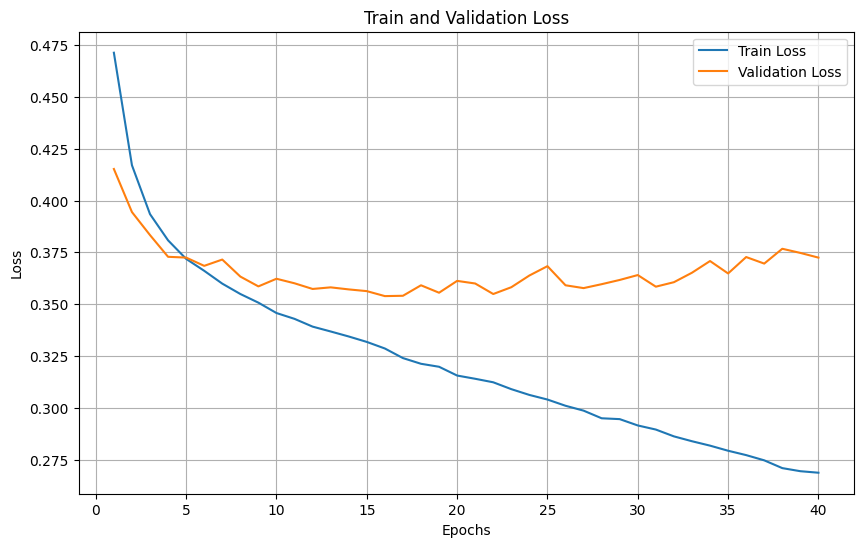

In [67]:
# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss') 
plt.title('Train and Validation Loss') 
plt.legend()
plt.grid()
plt.show()

## Test & 결과 제출

In [68]:
def test(model, test_loader, threshold=0.5):
    outputs = []

    model.eval()
    with torch.no_grad():
        for image, w2v, _ in tqdm(test_loader, desc='Test'):
            image, w2v = image.float().to(device), w2v.float().to(device)

            # Automatic Mixed Precision(AMP) 사용 (학습 속도, 메모리 절약)
            with torch.autocast(device_type='cuda', dtype=torch.float16):
                output = model(image, w2v) # ,w2v

            output = output.detach().sigmoid()
            output = (output > threshold).long()  # threshold를 기준으로 0/1 판별
            outputs.append(output)

    outputs = torch.cat(outputs, dim=0).cpu().numpy()

    return outputs

In [ ]:
from datetime import datetime

dt = datetime.now()
ctime = dt.strftime('%m%d_%H%M')  # 현재 월/일_시/분 확인

save_dir = './' # 최종 모델 저장 경로

threshold = 0.5
results = test(model, test_loader, threshold=threshold)


Test: 100%|██████████| 79/79 [00:02<00:00, 31.10it/s]


In [70]:
results 

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [71]:
submission = pd.read_csv(root_dir + 'sample_submission.csv')
submission.iloc[:, 1:] = results


submission.to_csv(save_dir + f'8_Albumentations2_{ctime}.csv', index=False)

## 참고

### Confusion matrix 분석

Precision score : 0.5903969957081545
Recall score : 0.47150814053127676
F1-score : 0.524297284421153


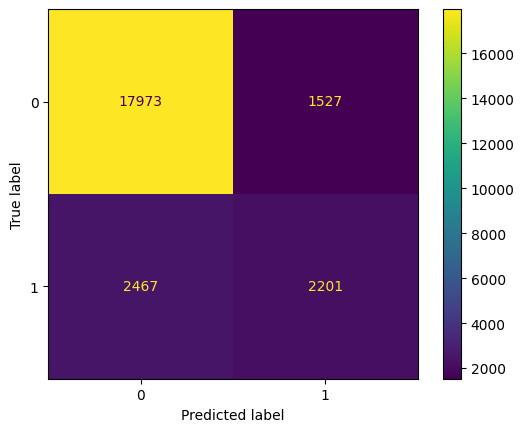

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

outputs = []
v_loss = 0
tp, tn, fp, fn = 0, 0, 0, 0

model.eval()
with torch.no_grad():
    for image, w2v, label in val_loader:
        image, w2v, label = image.float().to(device), w2v.float().to(device), label.float().to(device)

        with torch.autocast(device_type='cuda', dtype=torch.float16):
            output = model(image,w2v) #,w2v
            loss = criterion(output, label)

        output = output.detach().sigmoid()
        output = (output > threshold).long()
        label, output = label.cpu(), output.cpu()

        mcm = multilabel_confusion_matrix(label, output, samplewise=True)
        outputs.append(mcm)

        v_loss += loss.cpu().item()


conf = np.sum(np.concatenate(outputs), axis=0)
precision = conf[1, 1] / (conf[1, 1] + conf[0, 1])
recall = conf[1, 1] / (conf[1, 1] + conf[1, 0])
f1 = 2 * (precision * recall) / (precision + recall)

print(f'Precision score : {precision}')
print(f'Recall score : {recall}')
print(f'F1-score : {f1}')

disp = ConfusionMatrixDisplay(conf)
disp.plot()
plt.show()